# PIP

In [1]:
!pip install tensorflow

# IMPORTAR

In [2]:
import pandas as pd
import numpy as np
import json


# PREPROCESAMIENTO - NORMALIZACION
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer



In [3]:
# MODELO
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

2023-12-14 20:38:52.151312: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-14 20:38:52.207872: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 20:38:52.712761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 20:38:52.712906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 20:38:52.830214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [4]:
#Grafico
import matplotlib.pyplot as plt

# DIRECCION DE LOS ARCHIVOS

In [5]:
# DATA_DIR = "/Users/laqui/OneDrive/Documentos/PROYECTO_KAGGLE/"

DATA_DIR = '/home/alumno/Escritorio/SIC_Parte2/proyecto/predict-energy-behavior-of-prosumers/'

# Read CSVs and parse relevant date columns
train = pd.read_csv(DATA_DIR + "train.csv")
client = pd.read_csv(DATA_DIR + "client.csv")
historical_weather = pd.read_csv(DATA_DIR + "historical_weather.csv")
forecast_weather = pd.read_csv(DATA_DIR + "forecast_weather.csv")
electricity = pd.read_csv(DATA_DIR + "electricity_prices.csv")
gas = pd.read_csv(DATA_DIR + "gas_prices.csv")

In [6]:
station_to_county = pd.read_csv(DATA_DIR + "weather_station_to_county_mapping.csv")

In [7]:
with open('county_id_to_name_map.json', 'r') as file:
    county_data = json.load(file)['county_data']

# PREPROCESAMIENTO

In [8]:
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60


# FORECAST_WEATHER E HISTORICAL_WEATHER

## Seleccion de columnas utiles

In [9]:
## SELECCIONAR LAS COLUMNAS QUE USAR 

# ESPECIFICAR LAS COLUMNAS A USAR
# HISTORICAL
COLUMNAS_UTILES_H = ['latitude', 'longitude','datetime', 'temperature', 'snowfall','cloudcover_mid', 'direct_solar_radiation']
# FORECAST
COLUMNAS_UTILES_F = ['latitude', 'longitude','forecast_datetime','temperature','snowfall','cloudcover_mid', 'direct_solar_radiation']
# NUEVO 
forecast_weather = forecast_weather[COLUMNAS_UTILES_F]
historical_weather = historical_weather[COLUMNAS_UTILES_H]

## Convertir de latitud y longitud a county

In [10]:
## Lista limpia de latitudes y longitudes con su county y nombre, para poder ordenar las tablas de forecast

s1 = station_to_county[['latitude', 'longitude', 'county']]

In [11]:
s1['latitude'] = s1['latitude'].round(1)

/tmp/ipykernel_19893/771384542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s1['latitude'] = s1['latitude'].round(1)


In [12]:
s1['longitude'] = s1['longitude'].round(1)

/tmp/ipykernel_19893/2463813523.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s1['longitude'] = s1['longitude'].round(1)


In [13]:
s1['county'].fillna(12.0, inplace=True)

/tmp/ipykernel_19893/3132485876.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s1['county'].fillna(12.0, inplace=True)


### FORECAST

In [14]:
# Fucionar los datasets por las latitudes y longitudes
merged_df = pd.merge( forecast_weather,s1, on=['latitude', 'longitude'], how='left')

# Se agregan nuevas columnas a la tabla de forecast
new_column_values = merged_df[['county']]

# Se actualiza la tabla original con las nuevas columnas
forecast_weather[['county']] = new_column_values


In [15]:
forecast_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   latitude                float64
 1   longitude               float64
 2   forecast_datetime       object 
 3   temperature             float64
 4   snowfall                float64
 5   cloudcover_mid          float64
 6   direct_solar_radiation  float64
 7   county                  float64
dtypes: float64(7), object(1)
memory usage: 209.0+ MB


In [16]:
forecast_weather

,latitude,longitude,forecast_datetime,temperature,snowfall,cloudcover_mid,direct_solar_radiation,county
0,57.6,21.7,2021-09-01 01:00:00+00:00,15.655786,0.0,0.000000,0.0,12.0
1,57.6,22.2,2021-09-01 01:00:00+00:00,13.003931,0.0,0.000000,0.0,12.0
2,57.6,22.7,2021-09-01 01:00:00+00:00,14.206567,0.0,0.000000,0.0,12.0
3,57.6,23.2,2021-09-01 01:00:00+00:00,14.844507,0.0,0.000626,0.0,12.0
4,57.6,23.7,2021-09-01 01:00:00+00:00,15.293848,0.0,0.000015,0.0,12.0
...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,2023-06-01 00:00:00+00:00,10.150049,0.0,0.004059,0.0,12.0
3424508,59.7,26.7,2023-06-01 00:00:00+00:00,10.259790,0.0,0.198700,0.0,12.0
3424509,59.7,27.2,2023-06-01 00:00:00+00:00,10.467798,0.0,0.448853,0.0,12.0
3424510,59.7,27.7,2023-06-01 00:00:00+00:00,10.694116,0.0,0.997314,0.0,12.0


In [17]:
#Eliminar las filas que no tienen county asignado
forecast_weather.dropna(subset=['county'], inplace=True)

In [18]:
forecast_weather.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [19]:
# forecast_weather['datetime'] = forecast_weather['forecast_datetime'] 

In [20]:
# forecast_weather.drop(['forecast_datetime'], axis=1, inplace=True)

In [21]:
forecast_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 6 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   forecast_datetime       object 
 1   temperature             float64
 2   snowfall                float64
 3   cloudcover_mid          float64
 4   direct_solar_radiation  float64
 5   county                  float64
dtypes: float64(5), object(1)
memory usage: 156.8+ MB


### HISTORICAL

In [22]:
# Fucionar los datasets por las latitudes y longitudes
merged_df = pd.merge( historical_weather,s1, on=['latitude', 'longitude'], how='left')

# Se agregan nuevas columnas a la tabla de forecast
new_column_values = merged_df[['county']]

# Se actualiza la tabla original con las nuevas columnas
historical_weather[['county']] = new_column_values

In [23]:
#Eliminar las filas que no tienen county asignado
historical_weather.dropna(subset=['county'], inplace=True)

In [24]:
historical_weather.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [25]:
historical_weather.drop_duplicates(inplace=True)

In [26]:
historical_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1569512 entries, 0 to 1710799
Data columns (total 6 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   datetime                1569512 non-null  object 
 1   temperature             1569512 non-null  float64
 2   snowfall                1569512 non-null  float64
 3   cloudcover_mid          1569512 non-null  int64  
 4   direct_solar_radiation  1569512 non-null  float64
 5   county                  1569512 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 83.8+ MB


## NORMALIZACIÓN

In [27]:
# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()

#COLUMNAS DE INTERES
col_cambiar = ['temperature', 'snowfall','cloudcover_mid', 'direct_solar_radiation']
col_cambiar2 = ['temperature', 'snowfall', 'cloudcover_mid','direct_solar_radiation']

# Normalizar las columnas seleccionadas
# HISTORICAL
historical_weather[col_cambiar] = scaler.fit_transform(historical_weather[col_cambiar])
# FORECAST
forecast_weather[col_cambiar2] = scaler.fit_transform(forecast_weather[col_cambiar2])

## FORMATEAR HORAS

In [28]:
# If the column is not already in datetime format, you can convert it first

forecast_weather['forecast_datetime'] = pd.to_datetime(forecast_weather['forecast_datetime']).dt.tz_localize(None)


In [29]:
# If the column is not already in datetime format, you can convert it first
historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])

## AGREGAR LA COLUMNA DE MEDIANA PARA FILAS CON MISMA FECHA Y COUNTY

In [30]:
## forecast
forecast_weather['temperature_m'] = forecast_weather.groupby(['forecast_datetime', 'county'])['temperature'].transform('median')
forecast_weather['snowfall_m'] = forecast_weather.groupby(['forecast_datetime', 'county'])['snowfall'].transform('median')
forecast_weather['direct_solar_radiation_m'] = forecast_weather.groupby(['forecast_datetime', 'county'])['direct_solar_radiation'].transform('median')
forecast_weather['cloudcover_mid_m'] = forecast_weather.groupby(['forecast_datetime', 'county'])['cloudcover_mid'].transform('median')

## historical
historical_weather['temperature_m'] = historical_weather.groupby(['datetime', 'county'])['temperature'].transform('median')
historical_weather['snowfall_m'] = historical_weather.groupby(['datetime', 'county'])['snowfall'].transform('median')
historical_weather['direct_solar_radiation_m'] = historical_weather.groupby(['datetime', 'county'])['direct_solar_radiation'].transform('median')
historical_weather['cloudcover_mid_m'] = historical_weather.groupby(['datetime', 'county'])['cloudcover_mid'].transform('median')


# VISUALIZACIÓN FINAL

In [31]:
historical_weather = historical_weather.drop_duplicates(subset=['datetime','county'], keep='first')
historical_weather

,datetime,temperature,snowfall,cloudcover_mid,direct_solar_radiation,county,temperature_m,snowfall_m,direct_solar_radiation_m,cloudcover_mid_m
0,2021-09-01 00:00:00,0.676732,0.0,0.00,0.000000,12.0,0.665187,0.0,0.000000,0.000
10,2021-09-01 00:00:00,0.658970,0.0,0.48,0.000000,15.0,0.662522,0.0,0.000000,0.070
23,2021-09-01 00:00:00,0.662522,0.0,0.00,0.000000,13.0,0.662522,0.0,0.000000,0.000
29,2021-09-01 00:00:00,0.662522,0.0,0.00,0.000000,10.0,0.666075,0.0,0.000000,0.000
34,2021-09-01 00:00:00,0.621670,0.0,0.01,0.000000,7.0,0.625222,0.0,0.000000,0.010
...,...,...,...,...,...,...,...,...,...,...
1710749,2023-05-30 10:00:00,0.660746,0.0,0.37,0.415426,9.0,0.660746,0.0,0.423545,0.370
1710751,2023-05-30 10:00:00,0.653641,0.0,0.31,0.428958,3.0,0.648313,0.0,0.365359,0.460
1710763,2023-05-30 10:00:00,0.651865,0.0,0.33,0.431664,0.0,0.639432,0.0,0.418133,0.290
1710767,2023-05-30 10:00:00,0.625222,0.0,0.67,0.343708,5.0,0.623446,0.0,0.363329,0.690


In [32]:
forecast_weather = forecast_weather.drop_duplicates(subset=['forecast_datetime','county'], keep='first')

In [33]:
forecast_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244992 entries, 0 to 3424481
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   forecast_datetime         244992 non-null  datetime64[ns]
 1   temperature               244992 non-null  float64       
 2   snowfall                  244992 non-null  float64       
 3   cloudcover_mid            244992 non-null  float64       
 4   direct_solar_radiation    244992 non-null  float64       
 5   county                    244992 non-null  float64       
 6   temperature_m             244992 non-null  float64       
 7   snowfall_m                244992 non-null  float64       
 8   direct_solar_radiation_m  244992 non-null  float64       
 9   cloudcover_mid_m          244992 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 20.6 MB


# CLIENT, GAS_PRICE, ELECTRICITY_PRICE

## CLIENT

In [34]:
# Paso 2: Normalización 
scaler_client = MinMaxScaler()
client[['installed_capacity']] = scaler_client.fit_transform(client[['installed_capacity']])

# Paso 3: Extracción de Características Temporales
client['date'] = pd.to_datetime(client['date'])

# Crear nuevas variables temporales
client['day_of_week'] = client['date'].dt.dayofweek
client['month'] = client['date'].dt.month

# Paso 4: Codificación de Variables Categóricas
# Utilizamos OneHotEncoding para la variable 'product_type'
#client = pd.get_dummies(client, columns=['product_type'], drop_first=False)

# Eliminar columnas originales después de la codificación (ver primero cuál de los productos necesitamos antes de hacer drop)
#client.drop(['product_type_1', 'product_type_2', 'product_type_3'], axis=1, inplace=True)

# Paso 5: Creación de Variables Booleanas (no es necesario, RNN no trabaja con variables categóricas, solo numéricas)
# Creamos una variable booleana basada en la columna 'is_business'
# client['is_business'] = client['is_business'].astype(bool)

# Visualizar los primeros registros del conjunto de datos después del procesamiento
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   product_type        41919 non-null  int64         
 1   county              41919 non-null  int64         
 2   eic_count           41919 non-null  int64         
 3   installed_capacity  41919 non-null  float64       
 4   is_business         41919 non-null  int64         
 5   date                41919 non-null  datetime64[ns]
 6   data_block_id       41919 non-null  int64         
 7   day_of_week         41919 non-null  int64         
 8   month               41919 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 2.9 MB


## GAS PRICES

In [35]:
# Paso 2: Normalización
scaler_gas = MinMaxScaler()
gas[['lowest_price_per_mwh', 'highest_price_per_mwh']] = scaler_gas.fit_transform(
    gas[['lowest_price_per_mwh', 'highest_price_per_mwh']])

# Paso 3: Extracción de Características Temporales
gas['forecast_date'] = pd.to_datetime(gas['forecast_date'])
gas['origin_date'] = pd.to_datetime(gas['origin_date'])

# Crear nuevas variables temporales
# gas['hour_of_day'] = gas['forecast_date'].dt.hour
gas['day_of_week'] = gas['forecast_date'].dt.dayofweek
gas['month'] = gas['forecast_date'].dt.month

# Eliminar columnas innecesarias (ver si realmente hay que eliminar)
# gas.drop(['forecast_date', 'origin_date'], axis=1, inplace=True)

# Paso 5: Creación de Variables Booleanas  (revisar si más adelante es necesario)
# En este caso, puedes crear variables booleanas según ciertas condiciones
# Ejemplo: Crear una variable booleana basada en la relación entre lowest y highest prices
# gas['is_price_change'] = gas['lowest_price_per_mwh'] < gas['highest_price_per_mwh']

gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   forecast_date          637 non-null    datetime64[ns]
 1   lowest_price_per_mwh   637 non-null    float64       
 2   highest_price_per_mwh  637 non-null    float64       
 3   origin_date            637 non-null    datetime64[ns]
 4   data_block_id          637 non-null    int64         
 5   day_of_week            637 non-null    int64         
 6   month                  637 non-null    int64         
dtypes: datetime64[ns](2), float64(2), int64(3)
memory usage: 35.0 KB


## ELECTRICITY PRICES

In [36]:
# Paso 2: Normalización
scaler_electricity = MinMaxScaler()
electricity[['euros_per_mwh']] = scaler_electricity.fit_transform(electricity[['euros_per_mwh']])


# Paso 3: Extracción de Características Temporales
electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])
electricity['origin_date'] = pd.to_datetime(electricity['origin_date'])

# Crear nuevas variables temporales
# electricity['hour_of_day'] = electricity['forecast_date'].dt.hour
electricity['day_of_week'] = electricity['forecast_date'].dt.dayofweek
electricity['month'] = electricity['forecast_date'].dt.month

# Eliminar columnas innecesarias (ver si realmente hay que eliminar)
# electricity.drop(['forecast_date', 'origin_date'], axis=1, inplace=True)


# Paso 5: Creación de Variables Booleanas
# En este caso, puedes crear variables booleanas según ciertas condiciones
# Ejemplo: Crear una variable booleana basada en la relación entre lowest y highest prices (revisar si más adelante es necesario)
# electricity['is_price_change'] = electricity['lowest_price_per_mwh'] < electricity['highest_price_per_mwh']


electricity.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id,day_of_week,month
0,2021-09-01 00:00:00,0.025578,2021-08-31 00:00:00,1,2,9
1,2021-09-01 01:00:00,0.024678,2021-08-31 01:00:00,1,2,9
2,2021-09-01 02:00:00,0.024291,2021-08-31 02:00:00,1,2,9
3,2021-09-01 03:00:00,0.024174,2021-08-31 03:00:00,1,2,9
4,2021-09-01 04:00:00,0.024561,2021-08-31 04:00:00,1,2,9


# Preprocesamiento Train

In [37]:
# Paso 1: Manejo de Datos Faltantes (REVISAR SI SE LLEVAN A CERO O SE ELIMINA O PONER LA MEDIA DE CADA PRODUCT_ID!!)
# missing_values_train = train.isnull().sum()
# imputer_train = SimpleImputer(strategy='median')  
# train[['target']] = imputer_train.fit_transform(train[['target']])


train.drop(['row_id'], axis=1, inplace=True)
train = train.dropna(subset=['target'])

# Paso 2: Extracción de Características Temporales ()
train['datetime'] = pd.to_datetime(train['datetime'])
train['day_of_week'] = train['datetime'].dt.dayofweek
train['month'] = train['datetime'].dt.month
train['year'] = train['datetime'].dt.year  
train['hour_of_day'] = train['datetime'].dt.hour 

# Paso 3: Codificación de Variables Categóricas
# One-hot encoding para la columna 'product_type'
train = pd.get_dummies(train, columns=['product_type'], prefix='product_type', drop_first=False)

# Paso 4: Normalización (SI ES NECESARIO CAMBIAR A MINMAXSCALER)
scaler_train = StandardScaler()
train[['target']] = scaler_train.fit_transform(train[['target']])

# Crear dos nuevas columnas basadas en la condición booleana
train['consumption'] = np.where(train['is_consumption']==0, train['target'], 0)
train['production'] = np.where(train['is_consumption']==1, train['target'], 0)

# Eliminar la columna original si es necesario
train.drop(['target', 'is_consumption'], axis=1, inplace=True)

# mover los valores de la columna una linea arriba
train['production'] = train['production'].shift(-1)


/tmp/ipykernel_19893/4063044821.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['datetime'] = pd.to_datetime(train['datetime'])
/tmp/ipykernel_19893/4063044821.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['day_of_week'] = train['datetime'].dt.dayofweek
/tmp/ipykernel_19893/4063044821.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [38]:
# train.set_index('datetime', inplace=True)

In [39]:
train = train.loc[~((train['consumption'] == 0) & (train['production'] == 0))]

In [40]:
# Convert the entire column to float using astype()
train['county'] = train['county'].astype(float)

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008913 entries, 0 to 2018351
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   county              1008913 non-null  float64       
 1   is_business         1008913 non-null  int64         
 2   datetime            1008913 non-null  datetime64[ns]
 3   data_block_id       1008913 non-null  int64         
 4   prediction_unit_id  1008913 non-null  int64         
 5   day_of_week         1008913 non-null  int64         
 6   month               1008913 non-null  int64         
 7   year                1008913 non-null  int64         
 8   hour_of_day         1008913 non-null  int64         
 9   product_type_0      1008913 non-null  uint8         
 10  product_type_1      1008913 non-null  uint8         
 11  product_type_2      1008913 non-null  uint8         
 12  product_type_3      1008913 non-null  uint8         
 13  consumption 

In [42]:
train

,county,is_business,datetime,data_block_id,prediction_unit_id,day_of_week,month,year,hour_of_day,product_type_0,product_type_1,product_type_2,product_type_3,consumption,production
0,0.0,0,2021-09-01 00:00:00,0,0,2,9,2021,0,0,1,0,0,-0.301420,-0.196003
2,0.0,0,2021-09-01 00:00:00,0,1,2,9,2021,0,0,0,1,0,-0.302204,-0.283168
4,0.0,0,2021-09-01 00:00:00,0,2,2,9,2021,0,0,0,0,1,-0.299011,0.420014
6,0.0,1,2021-09-01 00:00:00,0,3,2,9,2021,0,1,0,0,0,-0.302204,-0.237334
8,0.0,1,2021-09-01 00:00:00,0,4,2,9,2021,0,0,1,0,0,-0.302204,0.249482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018344,15.0,0,2023-05-31 23:00:00,637,58,2,5,2023,23,0,0,0,1,-0.299690,-0.173198
2018346,15.0,1,2023-05-31 23:00:00,637,64,2,5,2023,23,1,0,0,0,-0.302204,-0.085346
2018348,15.0,1,2023-05-31 23:00:00,637,59,2,5,2023,23,0,1,0,0,-0.302204,-0.270974
2018350,15.0,1,2023-05-31 23:00:00,637,60,2,5,2023,23,0,0,0,1,-0.302204,-0.086438


### merge con data de weather

#### train_historic

In [43]:
train_historic = train.copy(deep=True)


In [44]:
train_historic

,county,is_business,datetime,data_block_id,prediction_unit_id,day_of_week,month,year,hour_of_day,product_type_0,product_type_1,product_type_2,product_type_3,consumption,production
0,0.0,0,2021-09-01 00:00:00,0,0,2,9,2021,0,0,1,0,0,-0.301420,-0.196003
2,0.0,0,2021-09-01 00:00:00,0,1,2,9,2021,0,0,0,1,0,-0.302204,-0.283168
4,0.0,0,2021-09-01 00:00:00,0,2,2,9,2021,0,0,0,0,1,-0.299011,0.420014
6,0.0,1,2021-09-01 00:00:00,0,3,2,9,2021,0,1,0,0,0,-0.302204,-0.237334
8,0.0,1,2021-09-01 00:00:00,0,4,2,9,2021,0,0,1,0,0,-0.302204,0.249482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018344,15.0,0,2023-05-31 23:00:00,637,58,2,5,2023,23,0,0,0,1,-0.299690,-0.173198
2018346,15.0,1,2023-05-31 23:00:00,637,64,2,5,2023,23,1,0,0,0,-0.302204,-0.085346
2018348,15.0,1,2023-05-31 23:00:00,637,59,2,5,2023,23,0,1,0,0,-0.302204,-0.270974
2018350,15.0,1,2023-05-31 23:00:00,637,60,2,5,2023,23,0,0,0,1,-0.302204,-0.086438


In [45]:
train_historic = pd.merge(train_historic, historical_weather[['datetime', 'county','temperature_m', 'snowfall_m','cloudcover_mid_m', 
                                                     'direct_solar_radiation_m']], on=['datetime', 'county'], how='left')



In [46]:
train_historic.set_index(['datetime'], inplace=True) 

In [47]:
train_historic

,county,is_business,data_block_id,prediction_unit_id,day_of_week,month,year,hour_of_day,product_type_0,product_type_1,product_type_2,product_type_3,consumption,production,temperature_m,snowfall_m,cloudcover_mid_m,direct_solar_radiation_m
datetime,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,0.0,0,0,0,2,9,2021,0,0,1,0,0,-0.301420,-0.196003,0.657194,0.0,0.035,0.0
2021-09-01 00:00:00,0.0,0,0,1,2,9,2021,0,0,0,1,0,-0.302204,-0.283168,0.657194,0.0,0.035,0.0
2021-09-01 00:00:00,0.0,0,0,2,2,9,2021,0,0,0,0,1,-0.299011,0.420014,0.657194,0.0,0.035,0.0
2021-09-01 00:00:00,0.0,1,0,3,2,9,2021,0,1,0,0,0,-0.302204,-0.237334,0.657194,0.0,0.035,0.0
2021-09-01 00:00:00,0.0,1,0,4,2,9,2021,0,0,1,0,0,-0.302204,0.249482,0.657194,0.0,0.035,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 23:00:00,15.0,0,637,58,2,5,2023,23,0,0,0,1,-0.299690,-0.173198,NaN,NaN,NaN,NaN
2023-05-31 23:00:00,15.0,1,637,64,2,5,2023,23,1,0,0,0,-0.302204,-0.085346,NaN,NaN,NaN,NaN
2023-05-31 23:00:00,15.0,1,637,59,2,5,2023,23,0,1,0,0,-0.302204,-0.270974,NaN,NaN,NaN,NaN


#### Forecast train

In [48]:
train_forecast = train.copy(deep=True)

In [49]:
train_forecast = pd.merge(train_forecast, forecast_weather[['forecast_datetime', 'county','temperature_m', 'snowfall_m','cloudcover_mid_m', 
                                                     'direct_solar_radiation_m']],
                          left_on=['datetime', 'county'],
                     right_on=['forecast_datetime', 'county'], how='left')


In [50]:
train_forecast.drop(['forecast_datetime'], axis=1, inplace=True)

In [51]:
train_forecast.set_index(['datetime'], inplace=True)

In [52]:
train_forecast

,county,is_business,data_block_id,prediction_unit_id,day_of_week,month,year,hour_of_day,product_type_0,product_type_1,product_type_2,product_type_3,consumption,production,temperature_m,snowfall_m,cloudcover_mid_m,direct_solar_radiation_m
datetime,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,0.0,0,0,0,2,9,2021,0,0,1,0,0,-0.301420,-0.196003,NaN,NaN,NaN,NaN
2021-09-01 00:00:00,0.0,0,0,1,2,9,2021,0,0,0,1,0,-0.302204,-0.283168,NaN,NaN,NaN,NaN
2021-09-01 00:00:00,0.0,0,0,2,2,9,2021,0,0,0,0,1,-0.299011,0.420014,NaN,NaN,NaN,NaN
2021-09-01 00:00:00,0.0,1,0,3,2,9,2021,0,1,0,0,0,-0.302204,-0.237334,NaN,NaN,NaN,NaN
2021-09-01 00:00:00,0.0,1,0,4,2,9,2021,0,0,1,0,0,-0.302204,0.249482,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 23:00:00,15.0,0,637,58,2,5,2023,23,0,0,0,1,-0.299690,-0.173198,0.619617,0.000789,0.0,0.00081
2023-05-31 23:00:00,15.0,1,637,64,2,5,2023,23,1,0,0,0,-0.302204,-0.085346,0.619617,0.000789,0.0,0.00081
2023-05-31 23:00:00,15.0,1,637,59,2,5,2023,23,0,1,0,0,-0.302204,-0.270974,0.619617,0.000789,0.0,0.00081


# Divide por cliente

In [53]:
## division en varios datasets

def split_dataframe_by_column(df, column_name):
    grouped = df.groupby(column_name)
    dataframes_dict = {name: group for name, group in grouped}
    return dataframes_dict

# Split the DataFrame by the 'Category' column
result_dataframes = split_dataframe_by_column(train_historic, 'prediction_unit_id')
for df in result_dataframes.values():
    print(df.columns)

Index(['county', 'is_business', 'data_block_id', 'prediction_unit_id',
       'day_of_week', 'month', 'year', 'hour_of_day', 'product_type_0',
       'product_type_1', 'product_type_2', 'product_type_3', 'consumption',
       'production', 'temperature_m', 'snowfall_m', 'cloudcover_mid_m',
       'direct_solar_radiation_m'],
      dtype='object')
Index(['county', 'is_business', 'data_block_id', 'prediction_unit_id',
       'day_of_week', 'month', 'year', 'hour_of_day', 'product_type_0',
       'product_type_1', 'product_type_2', 'product_type_3', 'consumption',
       'production', 'temperature_m', 'snowfall_m', 'cloudcover_mid_m',
       'direct_solar_radiation_m'],
      dtype='object')
Index(['county', 'is_business', 'data_block_id', 'prediction_unit_id',
       'day_of_week', 'month', 'year', 'hour_of_day', 'product_type_0',
       'product_type_1', 'product_type_2', 'product_type_3', 'consumption',
       'production', 'temperature_m', 'snowfall_m', 'cloudcover_mid_m',
       'dir

In [54]:
train_7= result_dataframes[7]


In [55]:
train_7

,county,is_business,data_block_id,prediction_unit_id,day_of_week,month,year,hour_of_day,product_type_0,product_type_1,product_type_2,product_type_3,consumption,production,temperature_m,snowfall_m,cloudcover_mid_m,direct_solar_radiation_m
datetime,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,1.0,0,0,7,2,9,2021,0,0,0,0,1,-0.302109,-0.277091,0.671403,0.0,0.00,0.0
2021-09-01 01:00:00,1.0,0,0,7,2,9,2021,1,0,0,0,1,-0.302104,-0.278941,0.669627,0.0,0.00,0.0
2021-09-01 02:00:00,1.0,0,0,7,2,9,2021,2,0,0,0,1,-0.302096,-0.279245,0.669627,0.0,0.00,0.0
2021-09-01 03:00:00,1.0,0,0,7,2,9,2021,3,0,0,0,1,-0.302055,-0.279717,0.667851,0.0,0.00,0.0
2021-09-01 04:00:00,1.0,0,0,7,2,9,2021,4,0,0,0,1,-0.302057,-0.279249,0.671403,0.0,0.02,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 19:00:00,1.0,0,637,7,2,5,2023,19,0,0,0,1,-0.231410,-0.275750,NaN,NaN,NaN,NaN
2023-05-31 20:00:00,1.0,0,637,7,2,5,2023,20,0,0,0,1,-0.274794,-0.260235,NaN,NaN,NaN,NaN
2023-05-31 21:00:00,1.0,0,637,7,2,5,2023,21,0,0,0,1,-0.294505,-0.251337,NaN,NaN,NaN,NaN


In [56]:
## segunda parte

In [57]:


from sklearn.metrics import mean_squared_error as mse


## funciona para automatizar los graficos 

def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end],color='blue', label='Prediccion')
    plt.plot(df['Actuals'][start:end],color='orange', label='Real')
    plt.legend()
    return df, mse(y, predictions)

In [58]:
temp_7 = train_7['temperature_m']

In [59]:
temp_df = pd.DataFrame({ 'Product_Type0':train_7['product_type_0'], 'Product_Type1':train_7['product_type_1'], 
                        'Product_Type2':train_7['product_type_2'], 'Product_Type3':train_7['product_type_3'], 
                        'Temperature':train_7['temperature_m'], 
                        'Snowfall':train_7['snowfall_m'], 'Cloudcover':train_7['cloudcover_mid_m'],
                        'Direct Solar radiation':train_7['direct_solar_radiation_m'], 'Business':train_7['is_business']})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Product_Type0,Product_Type1,Product_Type2,Product_Type3,Temperature,Snowfall,Cloudcover,Direct Solar radiation,Business,Seconds
datetime,,,,,,,,,,
2021-09-01 00:00:00,0,0,0,1,0.671403,0.0,0.00,0.0,0,1.630454e+09
2021-09-01 01:00:00,0,0,0,1,0.669627,0.0,0.00,0.0,0,1.630458e+09
2021-09-01 02:00:00,0,0,0,1,0.669627,0.0,0.00,0.0,0,1.630462e+09
2021-09-01 03:00:00,0,0,0,1,0.667851,0.0,0.00,0.0,0,1.630465e+09
2021-09-01 04:00:00,0,0,0,1,0.671403,0.0,0.02,0.0,0,1.630469e+09
...,...,...,...,...,...,...,...,...,...,...
2023-05-31 19:00:00,0,0,0,1,NaN,NaN,NaN,NaN,0,1.685560e+09
2023-05-31 20:00:00,0,0,0,1,NaN,NaN,NaN,NaN,0,1.685563e+09
2023-05-31 21:00:00,0,0,0,1,NaN,NaN,NaN,NaN,0,1.685567e+09


In [60]:
p_temp_df = pd.concat([train_7['consumption'], temp_df], axis=1)
p_temp_df.head()

,consumption,Product_Type0,Product_Type1,Product_Type2,Product_Type3,Temperature,Snowfall,Cloudcover,Direct Solar radiation,Business,Seconds
datetime,,,,,,,,,,,
2021-09-01 00:00:00,-0.302109,0,0,0,1,0.671403,0.0,0.00,0.0,0,1.630454e+09
2021-09-01 01:00:00,-0.302104,0,0,0,1,0.669627,0.0,0.00,0.0,0,1.630458e+09
2021-09-01 02:00:00,-0.302096,0,0,0,1,0.669627,0.0,0.00,0.0,0,1.630462e+09
2021-09-01 03:00:00,-0.302055,0,0,0,1,0.667851,0.0,0.00,0.0,0,1.630465e+09
2021-09-01 04:00:00,-0.302057,0,0,0,1,0.671403,0.0,0.02,0.0,0,1.630469e+09


In [61]:
hours=60*60
day = hours*24
year = 365.2425*day
p_temp_df['hours sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / hours))
p_temp_df['hours cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / hours))
p_temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
p_temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))

p_temp_df

,consumption,Product_Type0,Product_Type1,Product_Type2,Product_Type3,Temperature,Snowfall,Cloudcover,Direct Solar radiation,Business,Seconds,hours sin,hours cos,Day sin,Day cos
datetime,,,,,,,,,,,,,,,
2021-09-01 00:00:00,-0.302109,0,0,0,1,0.671403,0.0,0.00,0.0,0,1.630454e+09,2.447398e-10,1.0,-9.205063e-12,1.000000
2021-09-01 01:00:00,-0.302104,0,0,0,1,0.669627,0.0,0.00,0.0,0,1.630458e+09,1.655765e-12,1.0,2.588190e-01,0.965926
2021-09-01 02:00:00,-0.302096,0,0,0,1,0.669627,0.0,0.00,0.0,0,1.630462e+09,2.242330e-10,1.0,5.000000e-01,0.866025
2021-09-01 03:00:00,-0.302055,0,0,0,1,0.667851,0.0,0.00,0.0,0,1.630465e+09,-1.885099e-11,1.0,7.071068e-01,0.707107
2021-09-01 04:00:00,-0.302057,0,0,0,1,0.671403,0.0,0.02,0.0,0,1.630469e+09,2.037263e-10,1.0,8.660254e-01,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 19:00:00,-0.231410,0,0,0,1,NaN,NaN,NaN,NaN,0,1.685560e+09,-8.672750e-12,1.0,-9.659258e-01,0.258819
2023-05-31 20:00:00,-0.274794,0,0,0,1,NaN,NaN,NaN,NaN,0,1.685563e+09,2.139045e-10,1.0,-8.660254e-01,0.500000
2023-05-31 21:00:00,-0.294505,0,0,0,1,NaN,NaN,NaN,NaN,0,1.685567e+09,-2.917950e-11,1.0,-7.071068e-01,0.707107


In [62]:
p_temp_df = p_temp_df.drop('Seconds', axis=1)
p_temp_df.head()

,consumption,Product_Type0,Product_Type1,Product_Type2,Product_Type3,Temperature,Snowfall,Cloudcover,Direct Solar radiation,Business,hours sin,hours cos,Day sin,Day cos
datetime,,,,,,,,,,,,,,
2021-09-01 00:00:00,-0.302109,0,0,0,1,0.671403,0.0,0.00,0.0,0,2.447398e-10,1.0,-9.205063e-12,1.000000
2021-09-01 01:00:00,-0.302104,0,0,0,1,0.669627,0.0,0.00,0.0,0,1.655765e-12,1.0,2.588190e-01,0.965926
2021-09-01 02:00:00,-0.302096,0,0,0,1,0.669627,0.0,0.00,0.0,0,2.242330e-10,1.0,5.000000e-01,0.866025
2021-09-01 03:00:00,-0.302055,0,0,0,1,0.667851,0.0,0.00,0.0,0,-1.885099e-11,1.0,7.071068e-01,0.707107
2021-09-01 04:00:00,-0.302057,0,0,0,1,0.671403,0.0,0.02,0.0,0,2.037263e-10,1.0,8.660254e-01,0.500000


In [63]:
def df_to_X_y2(df, window_size=12):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)


In [64]:
X2, y2 = df_to_X_y2(p_temp_df)
X2.shape, y2.shape

((15296, 12, 14), (15296,))

In [65]:


X_train2, y_train2 = X2[:X2.shape[0]*65//100], y2[:X2.shape[0]*65//100]
X_val2, y_val2 = X2[X2.shape[0]*65//100:X2.shape[0]*85//100], y2[X2.shape[0]*65//100:X2.shape[0]*85//100]
X_test2, y_test2 = X2[X2.shape[0]*85//100:], y2[X2.shape[0]*85//100:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((9942, 12, 14), (9942,), (3059, 12, 14), (3059,), (2295, 12, 14), (2295,))

In [66]:
temp_training_mean = np.mean(X_train2[:, :, 0])
temp_training_std = np.std(X_train2[:, :, 0])
                           
def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
    return X

In [67]:
preprocess(X_train2)
preprocess(X_val2)
preprocess(X_test2)

array([[[-5.45696026e-01,  0.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00, -8.66025404e-01,  5.00000000e-01],
        [-5.45618575e-01,  0.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00, -7.07106781e-01,  7.07106781e-01],
        [-5.47409633e-01,  0.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00, -5.00000000e-01,  8.66025404e-01],
        ...,
        [-5.47409633e-01,  0.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00,  9.65925826e-01,  2.58819045e-01],
        [-5.46867475e-01,  0.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00,  1.00000000e+00,  1.02669102e-11],
        [-5.47351545e-01,  0.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00,  9.65925826e-01, -2.58819045e-01]],

       [[-5.45618575e-01,  0.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00, -7.07106781e-01,  7.07106781e-01],
        [-5.47409633e-01,  0.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00, -5.00000000e

In [68]:
# model9 = Sequential()
# model9.add(InputLayer((12, 14)))
# model9.add(LSTM(64, activation='tanh'))
# model9.add(Dense(32, 'relu'))
# model9.add(Dense(21, 'relu'))
# model9.add(Dropout(0.2))
# model9.add(Dense(8, 'relu'))
# model9.add(Dense(1, 'linear'))
# model9.summary()

In [69]:
# cp9 = ModelCheckpoint('model9/', save_best_only=True)
# model9.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [70]:
# model9.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=25, batch_size=5,callbacks=[cp9])

In [71]:
# plot_predictions1(model9, X_test2, y_test2, 0, 400)

In [72]:
from keras.metrics import MeanAbsolutePercentageError

In [87]:
model7 = Sequential()
model7.add(InputLayer((12, 14)))
model7.add(Conv1D(64, kernel_size=6, activation='relu'))
model7.add(Flatten())
model7.add(Dense(64, 'relu'))
model7.add(Dense(32, 'relu'))
model7.add(Dense(16, 'relu'))
model7.add(Dense(8, 'relu'))
model7.add(Dense(4, 'relu'))
model7.add(Dense(1, 'linear'))
model7.summary()

cp7 = ModelCheckpoint('model7/', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 7, 64)             5440      
                                                                 
 flatten_2 (Flatten)         (None, 448)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                28736     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 8)                 136       
                                                                 
 dense_16 (Dense)            (None, 4)                

In [74]:
# model7.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=15, batch_size=2, callbacks=[cp7])

In [75]:
# plot_predictions1(model7, X_test2, y_test2, 0, 1000)

In [76]:

def preprocess(X):
    
    temp_training_mean = np.mean(X[ 0])
    temp_training_std = np.std(X[0])

    X[ 0] = (X[ 0] - temp_training_mean) / temp_training_std
    return X

In [83]:
from tensorflow.keras.models import load_model

In [77]:
def df_to_X_y(df, window_size=12):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [88]:
X_test_total=[]
y_test_total=[]

hours=60*60
day = hours*24
    
#toma los valores del dictionario de cada cliente
for i in result_dataframes.values():
    
    #toma las columnas utiles del diccionario
    temp_df = pd.DataFrame({ 'Product_Type0':i['product_type_0'], 'Product_Type1':i['product_type_1'], 
                        'Product_Type2':i['product_type_2'], 'Product_Type3':i['product_type_3'], 
                        'Temperature':i['temperature_m'], 'Snowfall':i['snowfall_m'], 
                        'Cloudcover':i['cloudcover_mid_m'],
                        'Direct Solar radiation':i['direct_solar_radiation_m'], 'Business':i['is_business']})
    
    #crea la columna segundos
    temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
    
    #le une la columna de consumo de primera
    p_temp_df = pd.concat([i['consumption'], temp_df], axis=1)


    #crea las columnas seno y coseno del tiempo
    
    p_temp_df['hours sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / hours))
    p_temp_df['hours cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / hours))
    p_temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
    p_temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))

    p_temp_df = p_temp_df.drop('Seconds', axis=1)
    
    #crea la X y la y, con la ventana de 12 horas
    X1, y1 = df_to_X_y(p_temp_df)
    
    #Normalizacion de las variables 
#     preprocess(X1)
#     preprocess(y1)

    #Division en train, val y test
    X_train1, y_train1 = X1[:X1.shape[0]*75//100], y1[:X1.shape[0]*75//100]
    X_val1, y_val1 = X1[X1.shape[0]*75//100:X1.shape[0]*90//100], y1[X1.shape[0]*75//100:X1.shape[0]*90//100]
    X_test1, y_test1 = X1[X1.shape[0]*90//100:], y1[X1.shape[0]*90//100:]
    
    X_test_total.append(X_test1)
    y_test_total.append(y_test1)
    
    
#     print(X_train1)
    
    
    model7.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=15, batch_size=5,callbacks=[cp7])
    
    model7 = load_model('model7/')
    
#     train_predictions = model2.predict(X_train1).flatten()
#     train_results = pd.DataFrame(data={ 'Train Predictions':train_predictions, 'Actuals':y_train1})

#     plt.plot(train_results['Train Predictions'][50:250],color='blue', label='Prediccion')
#     plt.plot(train_results['Actuals'][50:250],color='orange', label='Real')
#     plt.title(titulo)
#     plt.legend()

Epoch 1/15
2264/2295 [============================>.] - ETA: 0s - loss: 0.0259 - root_mean_squared_error: 0.1609INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 5s 2ms/step - loss: 0.0258 - root_mean_squared_error: 0.1606 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1313
Epoch 2/15
2292/2295 [============================>.] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0981INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 4s 2ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1188
Epoch 3/15
2289/2295 [============================>.] - ETA: 0s - loss: 0.0073 - root_mean_squared_error: 0.0856INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 3s 1ms/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0992
Epoch 4/15
2266/2295 [============================>.] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0794INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 4s 2ms/step - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0880
Epoch 5/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0056 - root_mean_squared_error: 0.0749 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0928
Epoch 6/15
2287/2295 [============================>.] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0724INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 4s 2ms/step - loss: 0.0052 - root_mean_squared_error: 0.0724 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 7/15
2273/2295 [============================>.] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0703INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 4s 2ms/step - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0780
Epoch 8/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0047 - root_mean_squared_error: 0.0686 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0794
Epoch 9/15
2293/2295 [============================>.] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0680INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 4s 2ms/step - loss: 0.0046 - root_mean_squared_error: 0.0679 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0756
Epoch 10/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 11/15
2295/2295 [==============================] - 3s 2ms/step - loss: 0.0044 - root_mean_squared_error: 0.0667 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0775
Epoch 12/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0043 - root_mean_squared_error: 0.0652 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0760
Epoch 13/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0759
Epoch 14/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0041 - root_mean_squared_error: 0.0639 - val_loss: 0.0063 

INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 4s 2ms/step - loss: 0.0041 - root_mean_squared_error: 0.0637 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0732
Epoch 1/15
2279/2295 [============================>.] - ETA: 0s - loss: 1.4611e-04 - root_mean_squared_error: 0.0121INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 4s 2ms/step - loss: 1.4568e-04 - root_mean_squared_error: 0.0121 - val_loss: 9.0569e-05 - val_root_mean_squared_error: 0.0095
Epoch 2/15
2280/2295 [============================>.] - ETA: 0s - loss: 8.5801e-05 - root_mean_squared_error: 0.0093INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 4s 2ms/step - loss: 8.5594e-05 - root_mean_squared_error: 0.0093 - val_loss: 4.9112e-05 - val_root_mean_squared_error: 0.0070
Epoch 3/15
2275/2295 [============================>.] - ETA: 0s - loss: 8.3584e-05 - root_mean_squared_error: 0.0091INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 4s 2ms/step - loss: 8.3364e-05 - root_mean_squared_error: 0.0091 - val_loss: 2.7837e-05 - val_root_mean_squared_error: 0.0053
Epoch 4/15
2295/2295 [==============================] - 3s 1ms/step - loss: 7.0163e-05 - root_mean_squared_error: 0.0084 - val_loss: 2.8284e-05 - val_root_mean_squared_error: 0.0053
Epoch 5/15
2295/2295 [==============================] - 3s 1ms/step - loss: 6.2893e-05 - root_mean_squared_error: 0.0079 - val_loss: 4.0386e-05 - val_root_mean_squared_error: 0.0064
Epoch 6/15
2295/2295 [==============================] - 4s 2ms/step - loss: 5.5399e-05 - root_mean_squared_error: 0.0074 - val_loss: 3.6168e-05 - val_root_mean_squared_error: 0.0060
Epoch 7/15
2295/2295 [==============================] - 4s 2ms/step - loss: 5.2193e-05 - root_mean_squared_error: 0.0072 - val_loss: 3.3352e-05 - val_root_mean_squared_error: 0.0058
Epoch 8/15
2273/2295 [============================>.] - ETA: 0s - loss: 4.8850e-05 - root_mean_square

INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 4s 2ms/step - loss: 4.8869e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.4437e-05 - val_root_mean_squared_error: 0.0049
Epoch 9/15
2295/2295 [==============================] - 3s 1ms/step - loss: 4.6342e-05 - root_mean_squared_error: 0.0068 - val_loss: 3.9246e-05 - val_root_mean_squared_error: 0.0063
Epoch 10/15
2295/2295 [==============================] - 3s 1ms/step - loss: 4.3373e-05 - root_mean_squared_error: 0.0066 - val_loss: 4.2789e-05 - val_root_mean_squared_error: 0.0065
Epoch 11/15
2272/2295 [============================>.] - ETA: 0s - loss: 4.2486e-05 - root_mean_squared_error: 0.0065INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 4s 2ms/step - loss: 4.2483e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.8089e-05 - val_root_mean_squared_error: 0.0043
Epoch 12/15
2284/2295 [============================>.] - ETA: 0s - loss: 3.9249e-05 - root_mean_squared_error: 0.0063INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 4s 2ms/step - loss: 3.9505e-05 - root_mean_squared_error: 0.0063 - val_loss: 1.7666e-05 - val_root_mean_squared_error: 0.0042
Epoch 13/15
2295/2295 [==============================] - 3s 1ms/step - loss: 3.7440e-05 - root_mean_squared_error: 0.0061 - val_loss: 3.3488e-05 - val_root_mean_squared_error: 0.0058
Epoch 14/15
2252/2295 [============================>.] - ETA: 0s - loss: 3.7082e-05 - root_mean_squared_error: 0.0061INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 3s 1ms/step - loss: 3.6930e-05 - root_mean_squared_error: 0.0061 - val_loss: 1.3951e-05 - val_root_mean_squared_error: 0.0037
Epoch 15/15
2282/2295 [============================>.] - ETA: 0s - loss: 3.4475e-05 - root_mean_squared_error: 0.0059INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


2295/2295 [==============================] - 3s 2ms/step - loss: 3.4623e-05 - root_mean_squared_error: 0.0059 - val_loss: 1.2142e-05 - val_root_mean_squared_error: 0.0035
Epoch 1/15
2295/2295 [==============================] - 4s 1ms/step - loss: 0.0631 - root_mean_squared_error: 0.2512 - val_loss: 0.0464 - val_root_mean_squared_error: 0.2153
Epoch 2/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0495 - root_mean_squared_error: 0.2225 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2164
Epoch 3/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0477 - root_mean_squared_error: 0.2184 - val_loss: 0.0423 - val_root_mean_squared_error: 0.2056
Epoch 4/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0460 - root_mean_squared_error: 0.2146 - val_loss: 0.0436 - val_root_mean_squared_error: 0.2089
Epoch 5/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0452 - root_mean_squared_error: 0.2126 - val_loss: 0.04

Epoch 1/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0933 - root_mean_squared_error: 0.3055 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1683
Epoch 2/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0760 - root_mean_squared_error: 0.2756 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1527
Epoch 3/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0736 - root_mean_squared_error: 0.2714 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1544
Epoch 4/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0715 - root_mean_squared_error: 0.2673 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1551
Epoch 5/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0700 - root_mean_squared_error: 0.2646 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1505
Epoch 6/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0706 - root_mean_squared_error: 0.2657 - val_loss: 0

Epoch 1/15
2295/2295 [==============================] - 4s 1ms/step - loss: 1.6074e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.9027e-04 - val_root_mean_squared_error: 0.0138
Epoch 2/15
2295/2295 [==============================] - 3s 1ms/step - loss: 1.3010e-04 - root_mean_squared_error: 0.0114 - val_loss: 1.4584e-04 - val_root_mean_squared_error: 0.0121
Epoch 3/15
2295/2295 [==============================] - 3s 1ms/step - loss: 1.2629e-04 - root_mean_squared_error: 0.0112 - val_loss: 1.3237e-04 - val_root_mean_squared_error: 0.0115
Epoch 4/15
2295/2295 [==============================] - 3s 1ms/step - loss: 1.1939e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.4692e-04 - val_root_mean_squared_error: 0.0121
Epoch 5/15
2295/2295 [==============================] - 3s 1ms/step - loss: 1.1793e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.7377e-04 - val_root_mean_squared_error: 0.0132
Epoch 6/15
2295/2295 [==============================] - 3s 1ms/step - loss: 1.1445e-04 - r

Epoch 2/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0023 - root_mean_squared_error: 0.0483 - val_loss: 9.9920e-04 - val_root_mean_squared_error: 0.0316
Epoch 3/15
2295/2295 [==============================] - 3s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0473 - val_loss: 8.4749e-04 - val_root_mean_squared_error: 0.0291
Epoch 4/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0022 - root_mean_squared_error: 0.0467 - val_loss: 8.4296e-04 - val_root_mean_squared_error: 0.0290
Epoch 5/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 7.4730e-04 - val_root_mean_squared_error: 0.0273
Epoch 6/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 8.3169e-04 - val_root_mean_squared_error: 0.0288
Epoch 7/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0021 - root_mean_squared_error: 

Epoch 3/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0579
Epoch 4/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0055 - root_mean_squared_error: 0.0739 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0583
Epoch 5/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0054 - root_mean_squared_error: 0.0734 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611
Epoch 6/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 7/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0052 - root_mean_squared_error: 0.0718 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589
Epoch 8/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0051 - root_mean_squared_error: 0.0714 - val_loss: 0

INFO:tensorflow:Assets written to: model7/assets


1496/1496 [==============================] - 3s 2ms/step - loss: 1.0836e-05 - root_mean_squared_error: 0.0033 - val_loss: 3.3772e-06 - val_root_mean_squared_error: 0.0018
Epoch 2/15
1496/1496 [==============================] - 2s 1ms/step - loss: 9.0644e-06 - root_mean_squared_error: 0.0030 - val_loss: 1.4209e-05 - val_root_mean_squared_error: 0.0038
Epoch 3/15
1496/1496 [==============================] - 2s 1ms/step - loss: 9.5414e-06 - root_mean_squared_error: 0.0031 - val_loss: 6.8355e-06 - val_root_mean_squared_error: 0.0026
Epoch 4/15
1496/1496 [==============================] - 2s 1ms/step - loss: 8.9325e-06 - root_mean_squared_error: 0.0030 - val_loss: 4.3699e-06 - val_root_mean_squared_error: 0.0021
Epoch 5/15
1496/1496 [==============================] - 2s 1ms/step - loss: 9.1445e-06 - root_mean_squared_error: 0.0030 - val_loss: 4.2225e-06 - val_root_mean_squared_error: 0.0021
Epoch 6/15
1496/1496 [==============================] - 2s 1ms/step - loss: 8.6495e-06 - root_mean_sq

INFO:tensorflow:Assets written to: model7/assets


1496/1496 [==============================] - 3s 2ms/step - loss: 8.2266e-06 - root_mean_squared_error: 0.0029 - val_loss: 3.1745e-06 - val_root_mean_squared_error: 0.0018
Epoch 11/15
1496/1496 [==============================] - 2s 1ms/step - loss: 7.8348e-06 - root_mean_squared_error: 0.0028 - val_loss: 3.6436e-06 - val_root_mean_squared_error: 0.0019
Epoch 12/15
1496/1496 [==============================] - 2s 1ms/step - loss: 7.2761e-06 - root_mean_squared_error: 0.0027 - val_loss: 3.8656e-06 - val_root_mean_squared_error: 0.0020
Epoch 13/15
1496/1496 [==============================] - 2s 1ms/step - loss: 7.7729e-06 - root_mean_squared_error: 0.0028 - val_loss: 3.2434e-06 - val_root_mean_squared_error: 0.0018
Epoch 14/15
1496/1496 [==============================] - 2s 2ms/step - loss: 7.2112e-06 - root_mean_squared_error: 0.0027 - val_loss: 7.2579e-06 - val_root_mean_squared_error: 0.0027
Epoch 15/15
1496/1496 [==============================] - 2s 1ms/step - loss: 7.2885e-06 - root_me

Epoch 12/15
2295/2295 [==============================] - 3s 2ms/step - loss: 7.1026e-04 - root_mean_squared_error: 0.0267 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 13/15
2295/2295 [==============================] - 3s 1ms/step - loss: 7.1532e-04 - root_mean_squared_error: 0.0267 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 14/15
2295/2295 [==============================] - 3s 1ms/step - loss: 6.9242e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 15/15
2295/2295 [==============================] - 4s 2ms/step - loss: 6.9389e-04 - root_mean_squared_error: 0.0263 - val_loss: 9.9382e-04 - val_root_mean_squared_error: 0.0315
Epoch 1/15
2295/2295 [==============================] - 4s 1ms/step - loss: 0.0010 - root_mean_squared_error: 0.0324 - val_loss: 5.9984e-04 - val_root_mean_squared_error: 0.0245
Epoch 2/15
2295/2295 [==============================] - 3s 1ms/step - loss: 8.8068e-04 - root_mean_squ

2295/2295 [==============================] - 3s 1ms/step - loss: 2.0658e-04 - root_mean_squared_error: 0.0144 - val_loss: 2.2745e-04 - val_root_mean_squared_error: 0.0151
Epoch 13/15
2295/2295 [==============================] - 3s 1ms/step - loss: 2.0555e-04 - root_mean_squared_error: 0.0143 - val_loss: 2.5067e-04 - val_root_mean_squared_error: 0.0158
Epoch 14/15
2295/2295 [==============================] - 4s 2ms/step - loss: 2.1036e-04 - root_mean_squared_error: 0.0145 - val_loss: 2.4674e-04 - val_root_mean_squared_error: 0.0157
Epoch 15/15
2295/2295 [==============================] - 3s 1ms/step - loss: 2.0118e-04 - root_mean_squared_error: 0.0142 - val_loss: 2.4985e-04 - val_root_mean_squared_error: 0.0158
Epoch 1/15
2295/2295 [==============================] - 4s 1ms/step - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 2/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0026 - root_mean_squared_err

Epoch 13/15
909/909 [==============================] - 1s 1ms/step - loss: 1.9862e-05 - root_mean_squared_error: 0.0045 - val_loss: 7.1730e-06 - val_root_mean_squared_error: 0.0027
Epoch 14/15
909/909 [==============================] - 2s 2ms/step - loss: 1.7803e-05 - root_mean_squared_error: 0.0042 - val_loss: 5.1024e-06 - val_root_mean_squared_error: 0.0023
Epoch 15/15
909/909 [==============================] - 1s 1ms/step - loss: 1.8177e-05 - root_mean_squared_error: 0.0043 - val_loss: 1.0798e-05 - val_root_mean_squared_error: 0.0033
Epoch 1/15
2295/2295 [==============================] - 4s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 2/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 3/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0019 - root_mean_squared_error:

INFO:tensorflow:Assets written to: model7/assets


2115/2115 [==============================] - 4s 2ms/step - loss: 1.3816e-05 - root_mean_squared_error: 0.0037 - val_loss: 2.7209e-06 - val_root_mean_squared_error: 0.0016
Epoch 7/15
2115/2115 [==============================] - 3s 1ms/step - loss: 1.4141e-05 - root_mean_squared_error: 0.0038 - val_loss: 6.3751e-06 - val_root_mean_squared_error: 0.0025
Epoch 8/15
2115/2115 [==============================] - 3s 1ms/step - loss: 1.3738e-05 - root_mean_squared_error: 0.0037 - val_loss: 3.1296e-06 - val_root_mean_squared_error: 0.0018
Epoch 9/15
2115/2115 [==============================] - 3s 2ms/step - loss: 1.3630e-05 - root_mean_squared_error: 0.0037 - val_loss: 3.3463e-06 - val_root_mean_squared_error: 0.0018
Epoch 10/15
2094/2115 [============================>.] - ETA: 0s - loss: 1.3589e-05 - root_mean_squared_error: 0.0037INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


2115/2115 [==============================] - 3s 1ms/step - loss: 1.3541e-05 - root_mean_squared_error: 0.0037 - val_loss: 1.5196e-06 - val_root_mean_squared_error: 0.0012
Epoch 11/15
2115/2115 [==============================] - 3s 1ms/step - loss: 1.3105e-05 - root_mean_squared_error: 0.0036 - val_loss: 4.7777e-06 - val_root_mean_squared_error: 0.0022
Epoch 12/15
2115/2115 [==============================] - 4s 2ms/step - loss: 1.2712e-05 - root_mean_squared_error: 0.0036 - val_loss: 2.4016e-06 - val_root_mean_squared_error: 0.0015
Epoch 13/15
2115/2115 [==============================] - 3s 2ms/step - loss: 1.2058e-05 - root_mean_squared_error: 0.0035 - val_loss: 7.8861e-06 - val_root_mean_squared_error: 0.0028
Epoch 14/15
2115/2115 [==============================] - 3s 1ms/step - loss: 1.2269e-05 - root_mean_squared_error: 0.0035 - val_loss: 2.5620e-06 - val_root_mean_squared_error: 0.0016
Epoch 15/15
2110/2115 [============================>.] - ETA: 0s - loss: 1.2113e-05 - root_mean_s

INFO:tensorflow:Assets written to: model7/assets


2115/2115 [==============================] - 3s 2ms/step - loss: 1.2101e-05 - root_mean_squared_error: 0.0035 - val_loss: 1.5085e-06 - val_root_mean_squared_error: 0.0012
Epoch 1/15
2295/2295 [==============================] - 4s 1ms/step - loss: 0.0192 - root_mean_squared_error: 0.1384 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1482
Epoch 2/15
2295/2295 [==============================] - 4s 2ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1393
Epoch 3/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1413
Epoch 4/15
2295/2295 [==============================] - 4s 2ms/step - loss: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1354
Epoch 5/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0150 - root_mean_squared_error: 0.1225 - val_loss: 0.01

Epoch 1/15
2295/2295 [==============================] - 4s 1ms/step - loss: 0.0136 - root_mean_squared_error: 0.1165 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 2/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852
Epoch 3/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0114 - root_mean_squared_error: 0.1068 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 4/15
2295/2295 [==============================] - 4s 2ms/step - loss: 0.0110 - root_mean_squared_error: 0.1051 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874
Epoch 5/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0847
Epoch 6/15
2295/2295 [==============================] - 4s 2ms/step - loss: 0.0108 - root_mean_squared_error: 0.1038 - val_loss: 0

2295/2295 [==============================] - 4s 1ms/step - loss: 0.0037 - root_mean_squared_error: 0.0609 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 2/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0032 - root_mean_squared_error: 0.0567 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0519
Epoch 3/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0486
Epoch 4/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0031 - root_mean_squared_error: 0.0557 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0506
Epoch 5/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0030 - root_mean_squared_error: 0.0551 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0482
Epoch 6/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0030 - root_mean_squared_error: 0.0547 - val_loss: 0.0021 - val

2295/2295 [==============================] - 3s 1ms/step - loss: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 7.3189e-04 - val_root_mean_squared_error: 0.0271
Epoch 3/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 5.9781e-04 - val_root_mean_squared_error: 0.0245
Epoch 4/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 5.6038e-04 - val_root_mean_squared_error: 0.0237
Epoch 5/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0020 - root_mean_squared_error: 0.0446 - val_loss: 6.6720e-04 - val_root_mean_squared_error: 0.0258
Epoch 6/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 5.0678e-04 - val_root_mean_squared_error: 0.0225
Epoch 7/15
2295/2295 [==============================] - 3s 1ms/step - loss: 0.0019 - root_mean_squared_error: 0.0441 - va

Epoch 2/15
1856/1856 [==============================] - 3s 2ms/step - loss: 2.3819e-04 - root_mean_squared_error: 0.0154 - val_loss: 3.2495e-05 - val_root_mean_squared_error: 0.0057
Epoch 3/15
1856/1856 [==============================] - 3s 1ms/step - loss: 2.2335e-04 - root_mean_squared_error: 0.0149 - val_loss: 6.6244e-05 - val_root_mean_squared_error: 0.0081
Epoch 4/15
1856/1856 [==============================] - 3s 1ms/step - loss: 2.1662e-04 - root_mean_squared_error: 0.0147 - val_loss: 4.0032e-05 - val_root_mean_squared_error: 0.0063
Epoch 5/15
1856/1856 [==============================] - 3s 2ms/step - loss: 2.1446e-04 - root_mean_squared_error: 0.0146 - val_loss: 3.2427e-05 - val_root_mean_squared_error: 0.0057
Epoch 6/15
1856/1856 [==============================] - 3s 2ms/step - loss: 2.0816e-04 - root_mean_squared_error: 0.0144 - val_loss: 2.9913e-05 - val_root_mean_squared_error: 0.0055
Epoch 7/15
1856/1856 [==============================] - 3s 2ms/step - loss: 2.0835e-04 - r

In [110]:
X_test_total=[]
y_test_total=[]

hours=60*60
day = hours*24
    
#toma los valores del dictionario de cada cliente
for i in result_dataframes.values():
    
    #toma las columnas utiles del diccionario
    temp_df = pd.DataFrame({ 'Product_Type0':i['product_type_0'], 'Product_Type1':i['product_type_1'], 
                        'Product_Type2':i['product_type_2'], 'Product_Type3':i['product_type_3'], 
                        'Temperature':i['temperature_m'], 'Snowfall':i['snowfall_m'], 
                        'Cloudcover':i['cloudcover_mid_m'],
                        'Direct Solar radiation':i['direct_solar_radiation_m'], 'Business':i['is_business']})
    
    #crea la columna segundos
    temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
    
    #le une la columna de consumo de primera
    p_temp_df = pd.concat([i['consumption'], temp_df], axis=1)


    #crea las columnas seno y coseno del tiempo
    
    p_temp_df['hours sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / hours))
    p_temp_df['hours cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / hours))
    p_temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
    p_temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))

    p_temp_df = p_temp_df.drop('Seconds', axis=1)
    
    #crea la X y la y, con la ventana de 12 horas
    X1, y1 = df_to_X_y(p_temp_df)
    

    #Division en train, val y test
    X_train1, y_train1 = X1[:X1.shape[0]*75//100], y1[:X1.shape[0]*75//100]
    X_val1, y_val1 = X1[X1.shape[0]*75//100:X1.shape[0]*90//100], y1[X1.shape[0]*75//100:X1.shape[0]*90//100]
    X_test1, y_test1 = X1[X1.shape[0]*90//100:], y1[X1.shape[0]*90//100:]
    
    
    
    X_test_total.append(X_test1)
    y_test_total.append(y_test1)

In [113]:
X_test_total[0].shape

(1530, 12, 14)

In [ ]:
## funciona para automatizar los graficos 

def plot_predictions2(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end],color='blue', label='Prediccion')
    plt.plot(df['Actuals'][start:end],color='orange', label='Real')
    plt.legend()
    return df, mse(y, predictions)

In [120]:
import seaborn as sns

48/48 [==============================] - 0s 540us/step


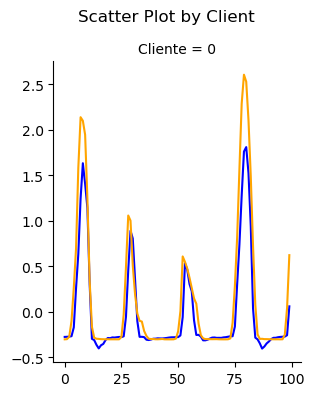

48/48 [==============================] - 0s 563us/step


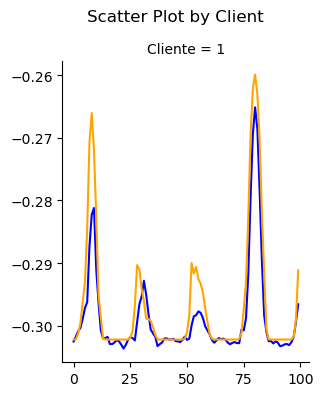

48/48 [==============================] - 0s 587us/step


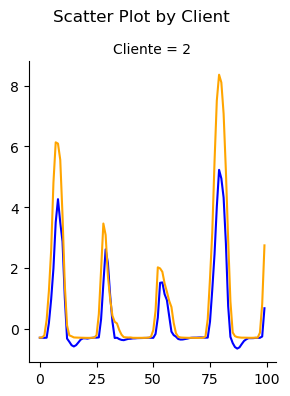

48/48 [==============================] - 0s 549us/step


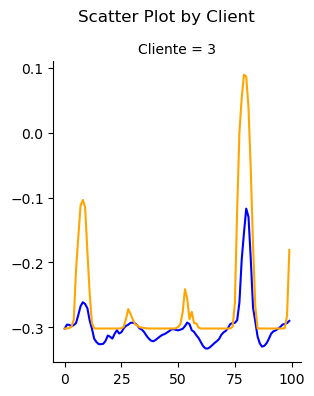

48/48 [==============================] - 0s 538us/step


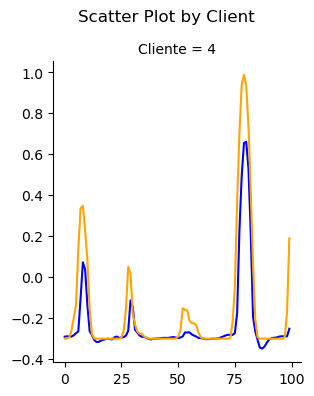

48/48 [==============================] - 0s 521us/step


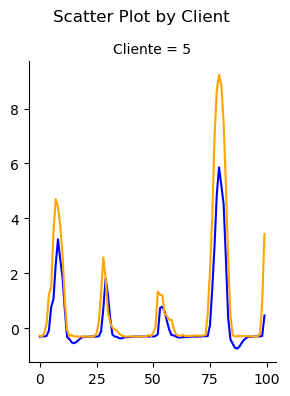

48/48 [==============================] - 0s 620us/step


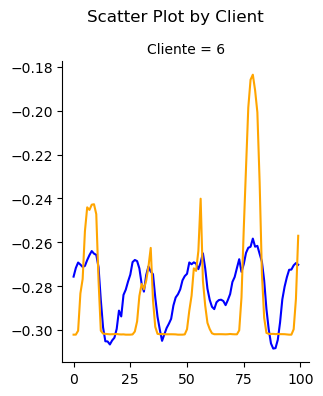

48/48 [==============================] - 0s 572us/step


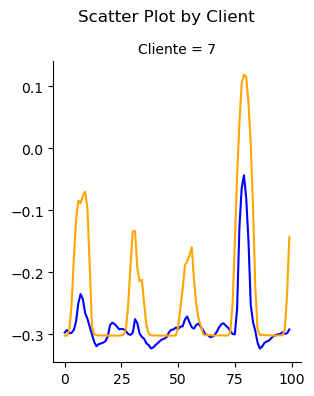

48/48 [==============================] - 0s 584us/step


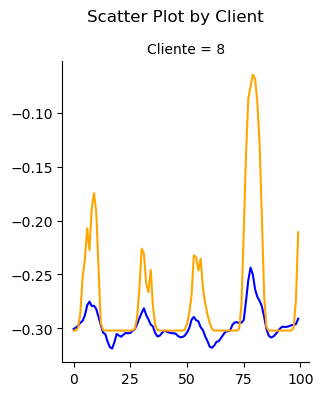

48/48 [==============================] - 0s 519us/step


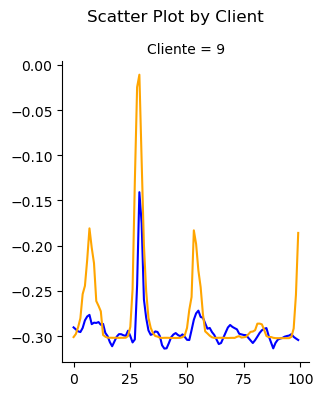

48/48 [==============================] - 0s 548us/step


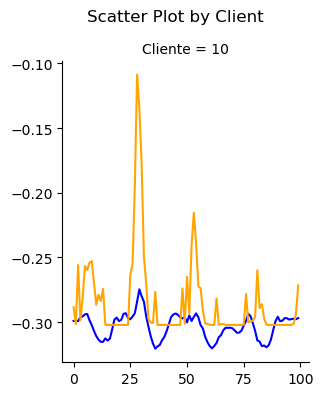

48/48 [==============================] - 0s 534us/step


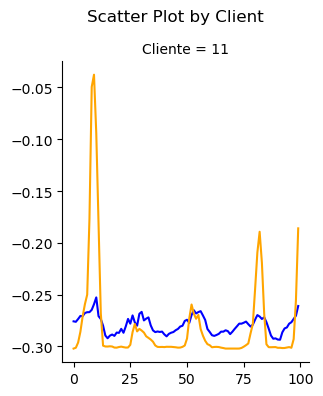

48/48 [==============================] - 0s 537us/step


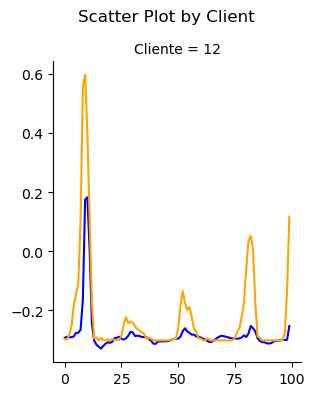

48/48 [==============================] - 0s 533us/step


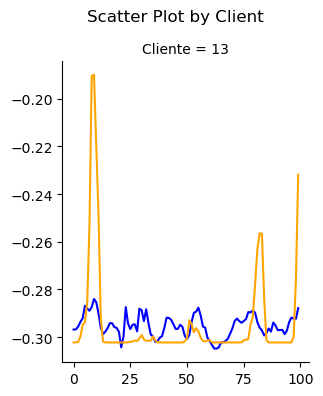

48/48 [==============================] - 0s 530us/step


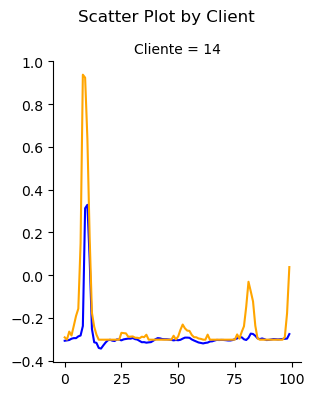

48/48 [==============================] - 0s 606us/step


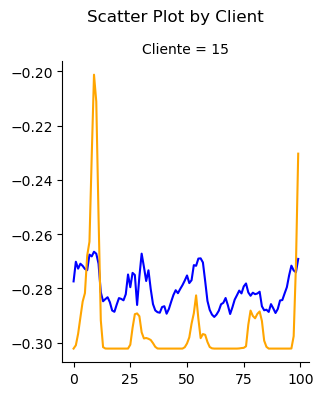

48/48 [==============================] - 0s 553us/step


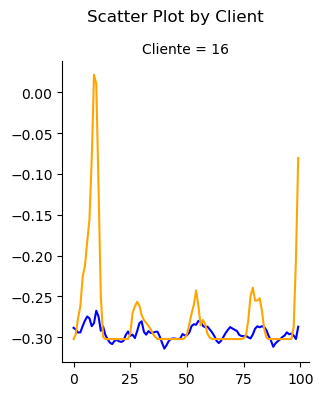

48/48 [==============================] - 0s 561us/step


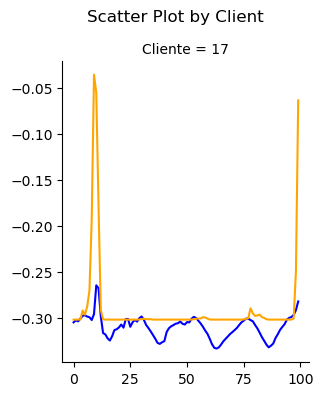

48/48 [==============================] - 0s 530us/step


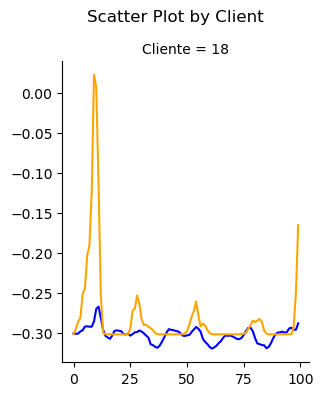

48/48 [==============================] - 0s 528us/step


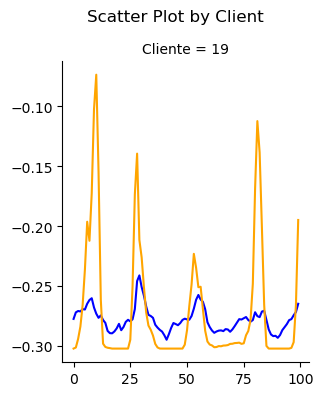

48/48 [==============================] - 0s 552us/step


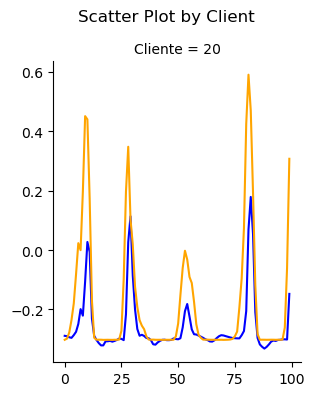

46/46 [==============================] - 0s 531us/step


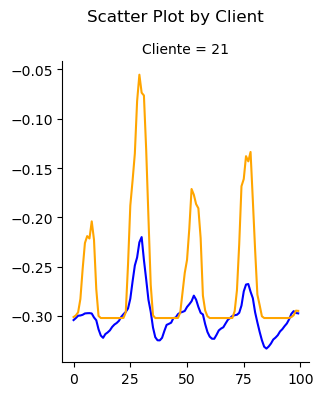

48/48 [==============================] - 0s 532us/step


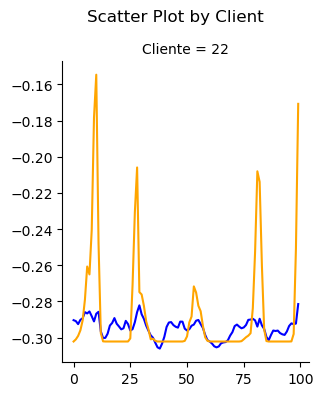

48/48 [==============================] - 0s 523us/step


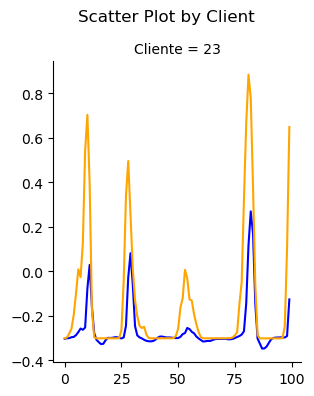

48/48 [==============================] - 0s 584us/step


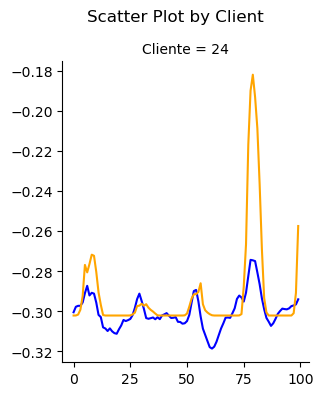

48/48 [==============================] - 0s 528us/step


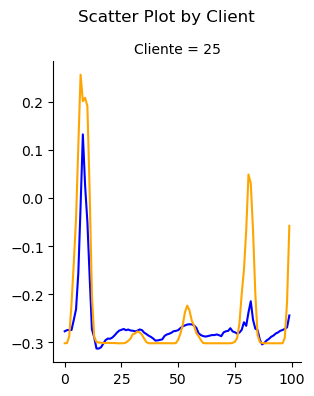

32/32 [==============================] - 0s 569us/step


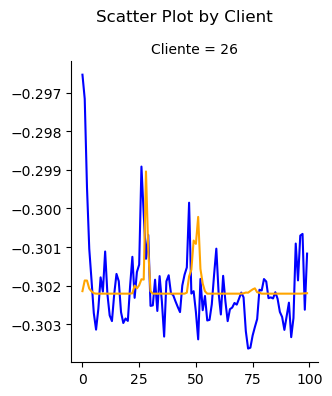

48/48 [==============================] - 0s 491us/step


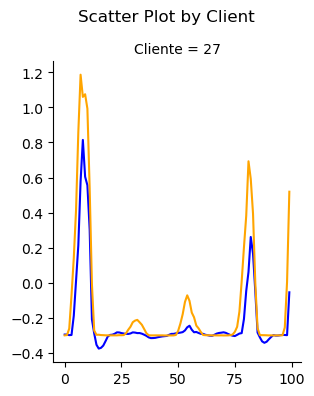

48/48 [==============================] - 0s 521us/step


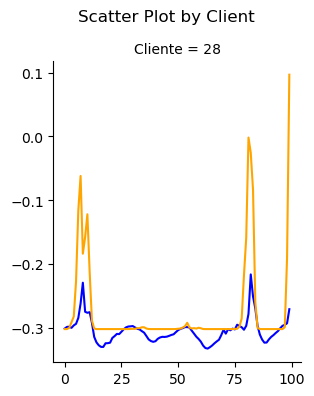

48/48 [==============================] - 0s 541us/step


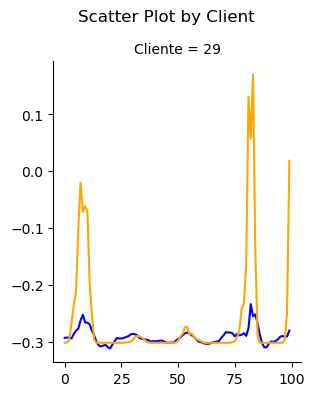

48/48 [==============================] - 0s 627us/step


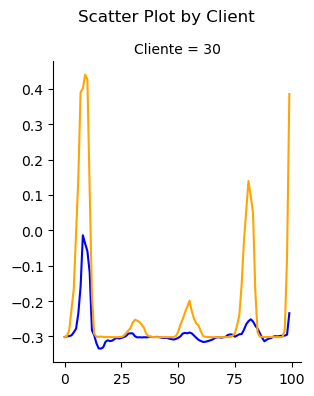

48/48 [==============================] - 0s 560us/step


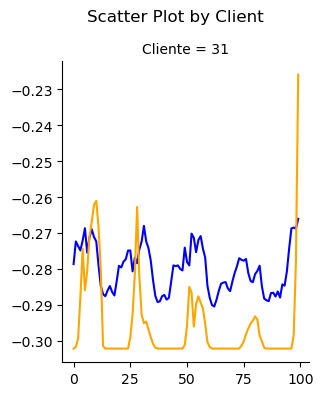

48/48 [==============================] - 0s 527us/step


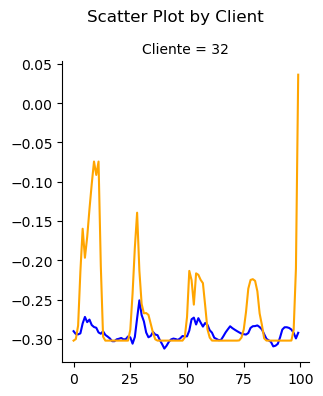

48/48 [==============================] - 0s 516us/step


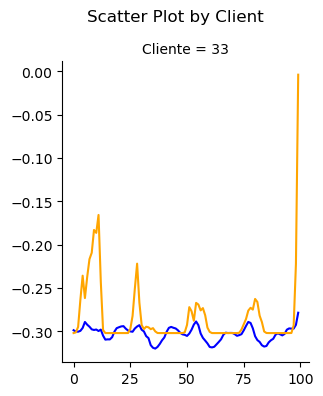

48/48 [==============================] - 0s 565us/step


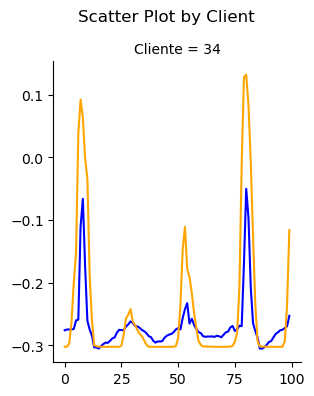

48/48 [==============================] - 0s 549us/step


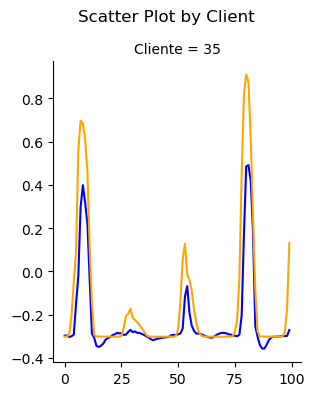

48/48 [==============================] - 0s 549us/step


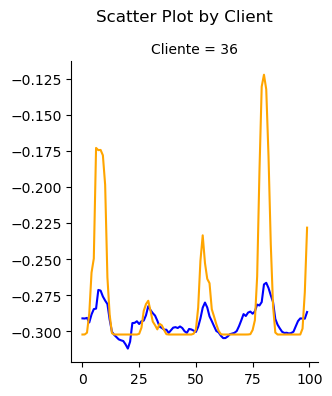

48/48 [==============================] - 0s 548us/step


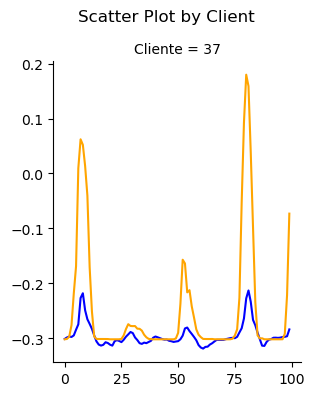

48/48 [==============================] - 0s 526us/step


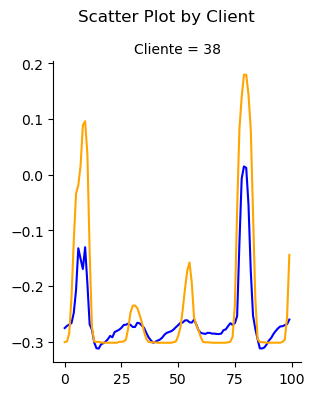

48/48 [==============================] - 0s 519us/step


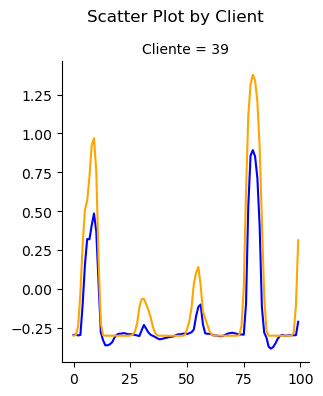

48/48 [==============================] - 0s 521us/step


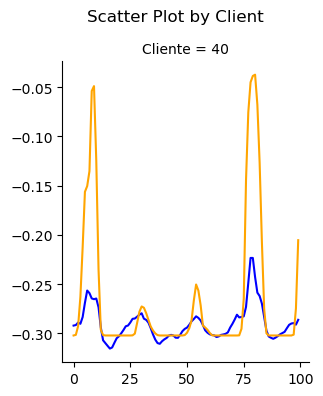

19/19 [==============================] - 0s 609us/step


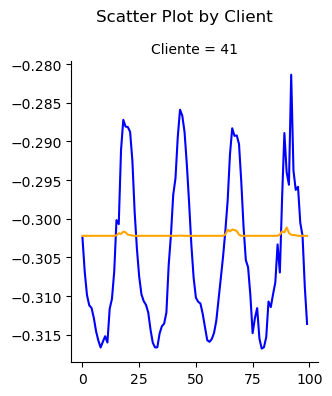

48/48 [==============================] - 0s 535us/step


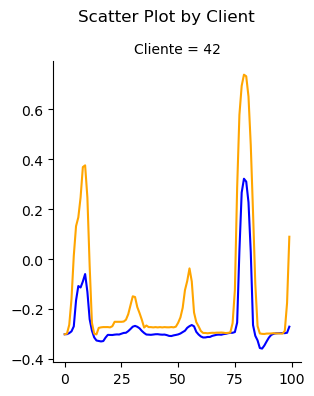

48/48 [==============================] - 0s 527us/step


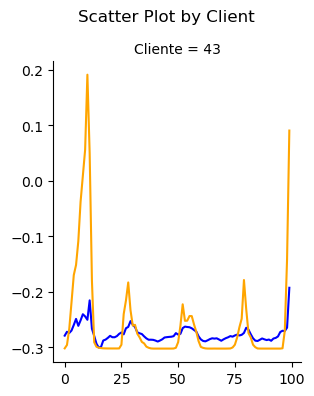

45/45 [==============================] - 0s 539us/step


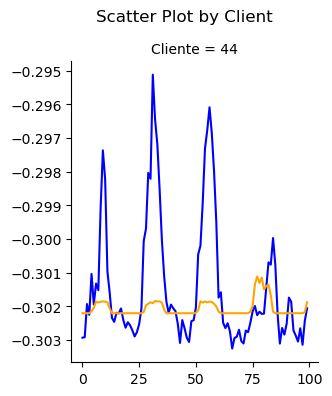

48/48 [==============================] - 0s 524us/step


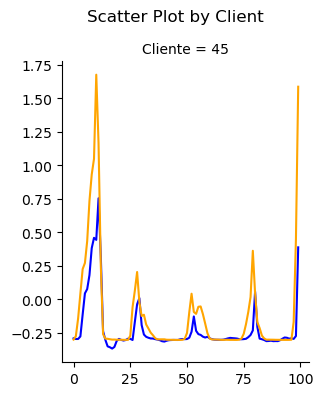

48/48 [==============================] - 0s 509us/step


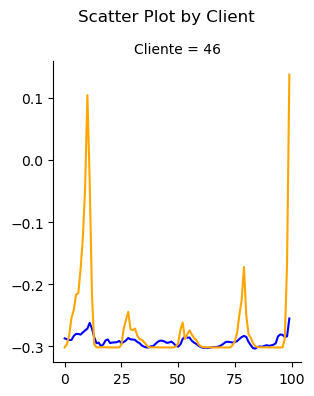

38/38 [==============================] - 0s 544us/step


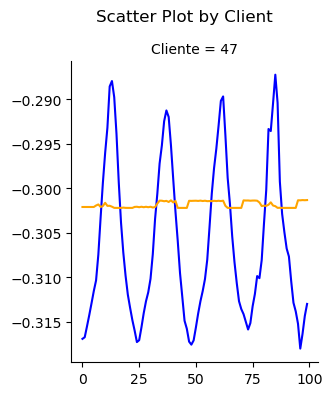

48/48 [==============================] - 0s 570us/step


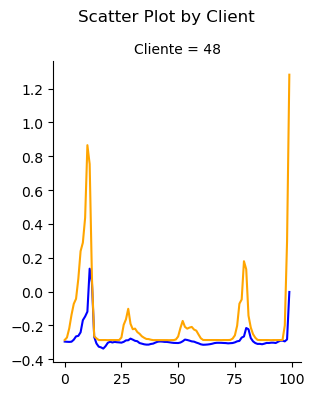

48/48 [==============================] - 0s 530us/step


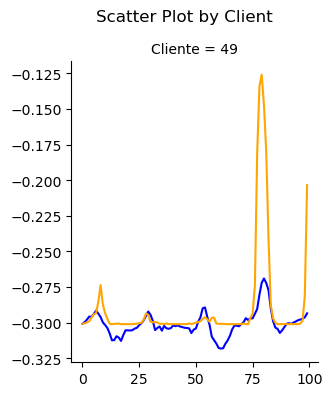

48/48 [==============================] - 0s 538us/step


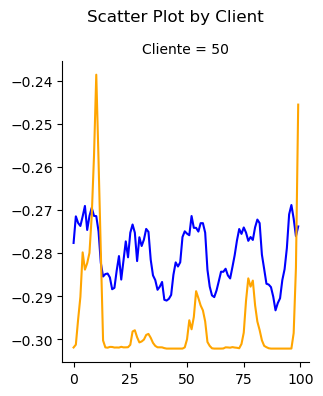

48/48 [==============================] - 0s 640us/step


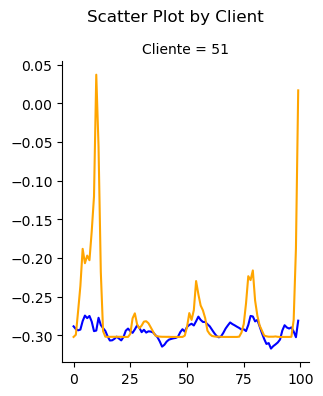

48/48 [==============================] - 0s 535us/step


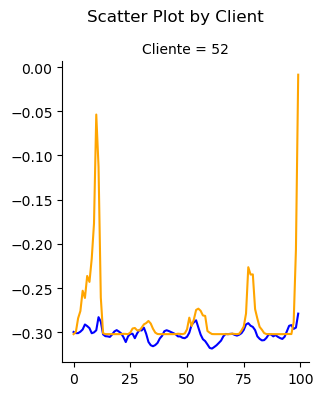

48/48 [==============================] - 0s 596us/step


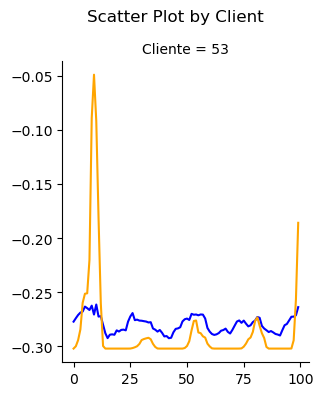

48/48 [==============================] - 0s 970us/step


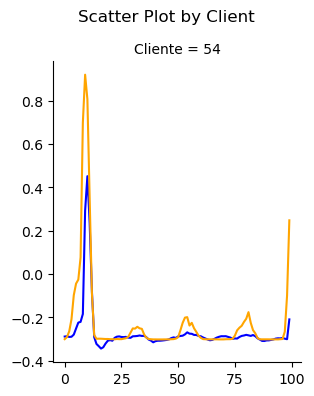

48/48 [==============================] - 0s 508us/step


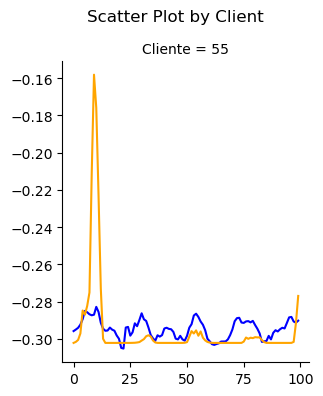

48/48 [==============================] - 0s 589us/step


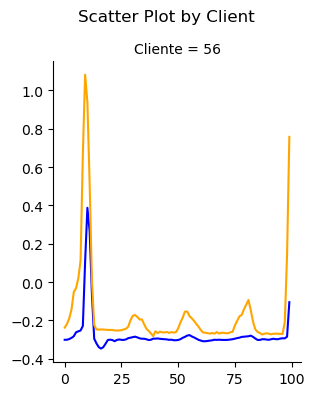

48/48 [==============================] - 0s 545us/step


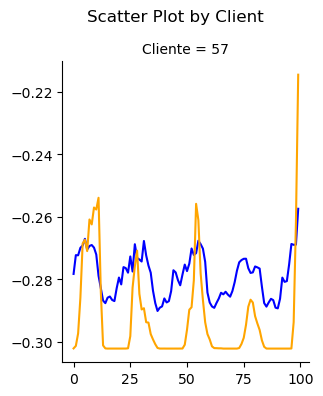

48/48 [==============================] - 0s 578us/step


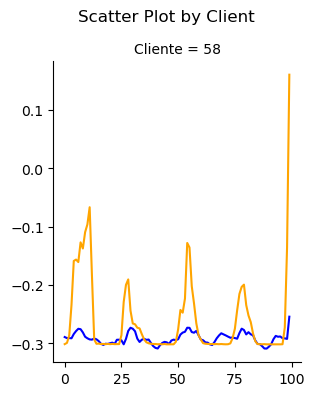

48/48 [==============================] - 0s 524us/step


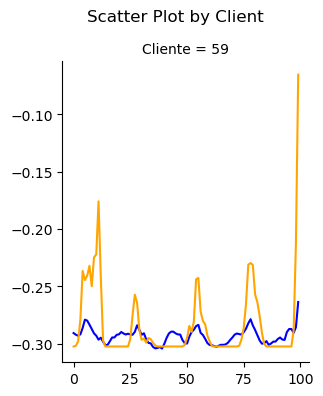

48/48 [==============================] - 0s 541us/step


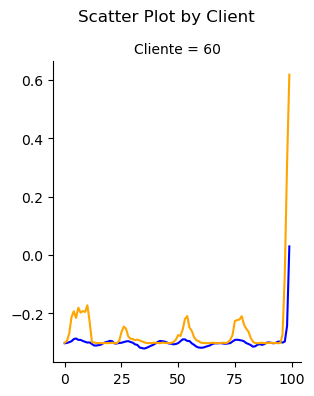

46/46 [==============================] - 0s 537us/step


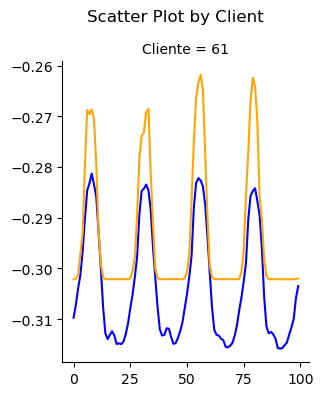

46/46 [==============================] - 0s 536us/step


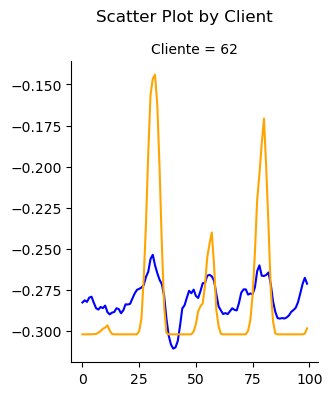

46/46 [==============================] - 0s 535us/step


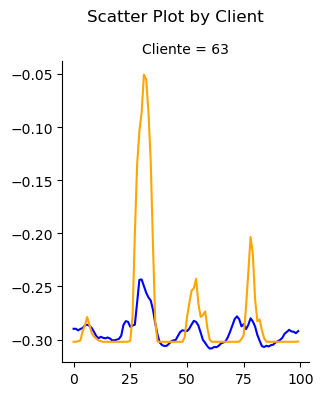

41/41 [==============================] - 0s 538us/step


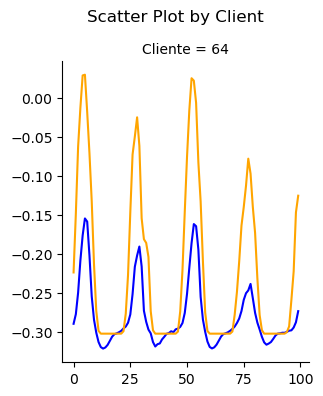

39/39 [==============================] - 0s 681us/step


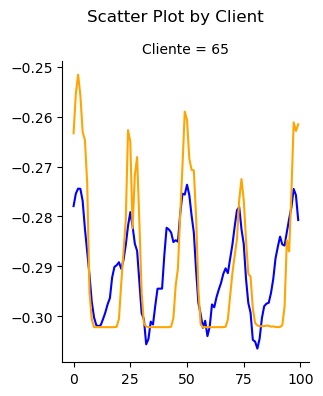

39/39 [==============================] - 0s 551us/step


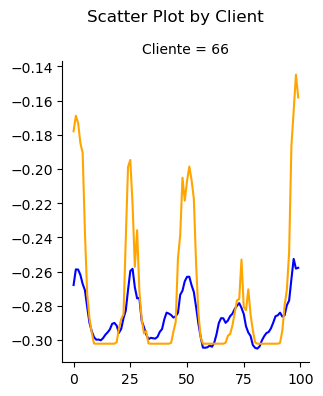

37/37 [==============================] - 0s 559us/step


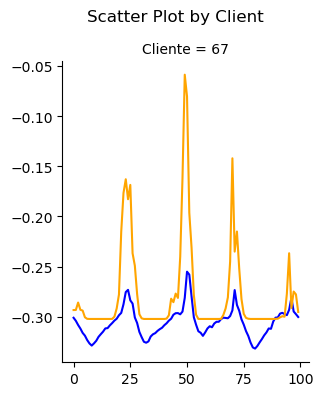

6/6 [==============================] - 0s 716us/step


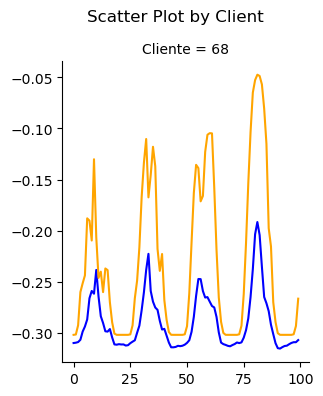

In [123]:
start=0
end=100

for n in range( len(X_test_total)):
    cliente_ = X_test_total[n]
    train_predictions = model7.predict(cliente_).flatten()
    y_cliente_ = y_test_total[n]
    train_results = pd.DataFrame(data={ 'Train Predictions':train_predictions, 'Actuals':y_cliente_, 'Cliente':n})
    
    # Create a FacetGrid
    g = sns.FacetGrid(train_results, col="Cliente", height=4, aspect=0.8)

    # Map a plot type to the grid
    (plt.plot(train_results['Train Predictions'][start:end],color='blue', label='Prediccion'))
    (plt.plot(train_results['Actuals'][start:end],color='orange', label='Real'))

    # Add a title
    g.fig.suptitle('Scatter Plot by Client')

    # Adjust the layout
    plt.subplots_adjust(top=0.85)

    # Show the plot
    plt.show()


In [ ]:
start=0
end=100

for n in range( len(X_test_total)):
    cliente_ = X_test_total[n]
    train_predictions = model7.predict(cliente_).flatten()
    y_cliente_ = y_test_total[n]
    train_results = pd.DataFrame(data={ 'Train Predictions':train_predictions, 'Actuals':y_cliente_, 'Cliente':n})
    
    # Create a FacetGrid
    g = sns.FacetGrid(train_results, col="Cliente", height=4, aspect=0.8)

    # Map a plot type to the grid
    (plt.plot(train_results['Train Predictions'][start:end],color='blue', label='Prediccion'))
    (plt.plot(train_results['Actuals'][start:end],color='orange', label='Real'))

    # Add a title
    g.fig.suptitle('Scatter Plot by Client')

    # Adjust the layout
    plt.subplots_adjust(top=0.85)

    # Show the plot
    plt.show()
